# GuestEnv Scenario Tests

This notebook runs the GuestEnv environment in five different scenarios. Each scenario logs phonemes per agent and rewards, then plots the results.

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))
from src.env.env_gym import GuestEnv

In [2]:
def run_env(env, actions, steps=200, seed=42):
    obs, info = env.reset(seed=seed)
    phonemes, rewards = [], []
    for i in range(steps):
        act = actions[i] if i < len(actions) else actions[-1]
        obs, reward, terminated, truncated, info = env.step(act)
        phonemes.append(info['phoneme'].copy())
        rewards.append(reward)
        if terminated or truncated:
            break
    return np.array(phonemes), np.array(rewards)

def plot_results(phonemes, rewards, title):
    steps = np.arange(len(rewards))
    plt.figure(figsize=(9,4))
    for a in range(phonemes.shape[1]):
        plt.plot(steps, phonemes[:, a], label=f'Agent {a}')
    plt.xlabel('Step'); plt.ylabel('Phonemes'); plt.title(title + ' - Phonemes')
    plt.legend(); plt.grid(True); plt.show()
    plt.figure(figsize=(9,4))
    plt.plot(steps, rewards, label='Reward')
    plt.xlabel('Step'); plt.ylabel('Reward'); plt.title(title + ' - Reward')
    plt.grid(True); plt.show()

## Scenario 1: Baseline
No guest actions are taken.

In [3]:
env = GuestEnv(max_steps=200, reward_shaping=False)
env.agent_params[0].update({'min_energy_to_speak':0.6,'energy_gain':0.01,'energy_decay':0.15,'max_speaking_time':2,'phonemes_per_step':1})
env.agent_params[1].update({'min_energy_to_speak':0.3,'energy_gain':0.05,'energy_decay':0.10,'max_speaking_time':5,'phonemes_per_step':2})
env.agent_params[2].update({'min_energy_to_speak':0.1,'energy_gain':0.10,'energy_decay':0.05,'max_speaking_time':8,'phonemes_per_step':4})
actions = [0]*200

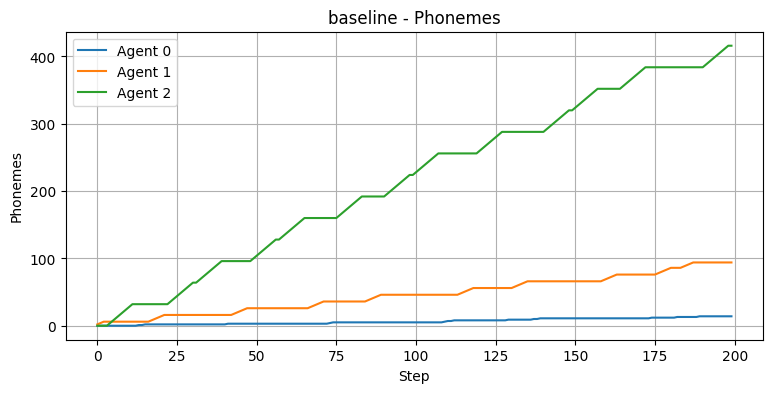

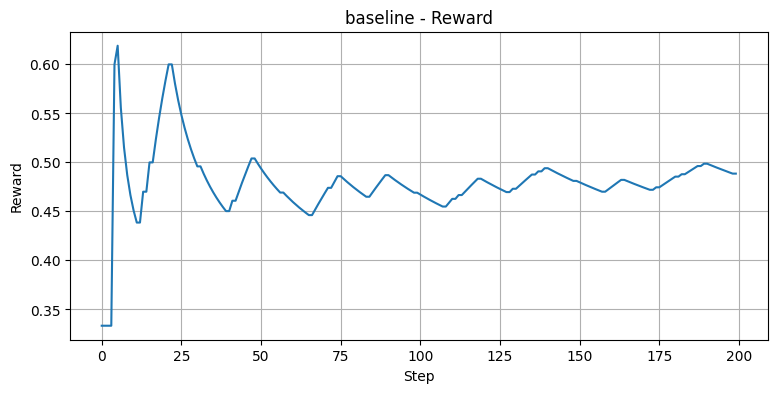

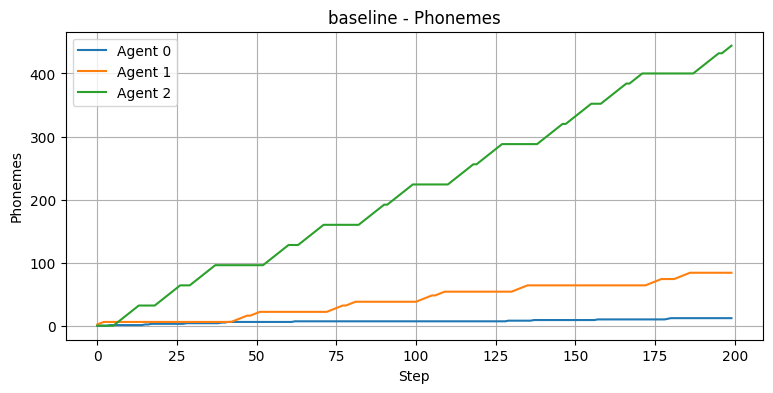

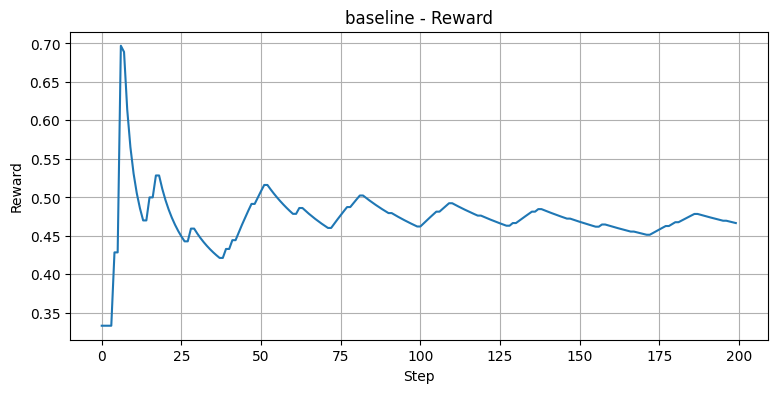

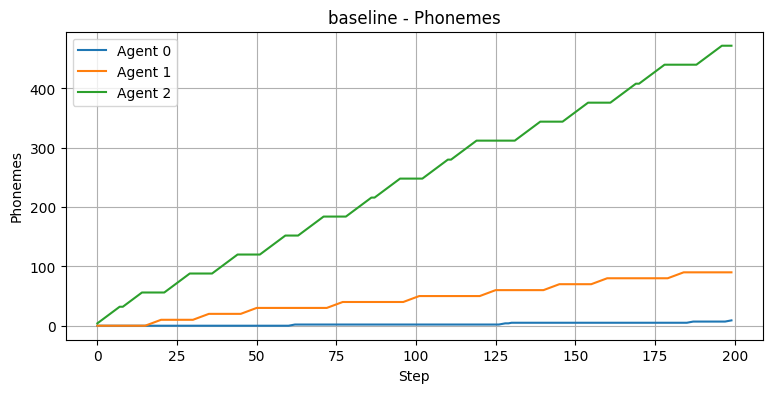

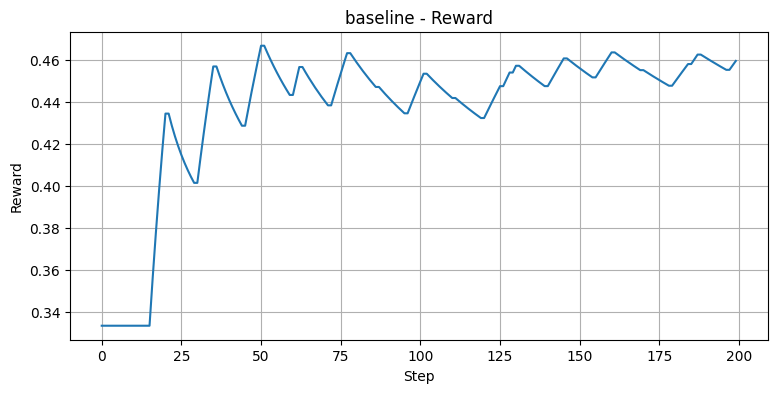

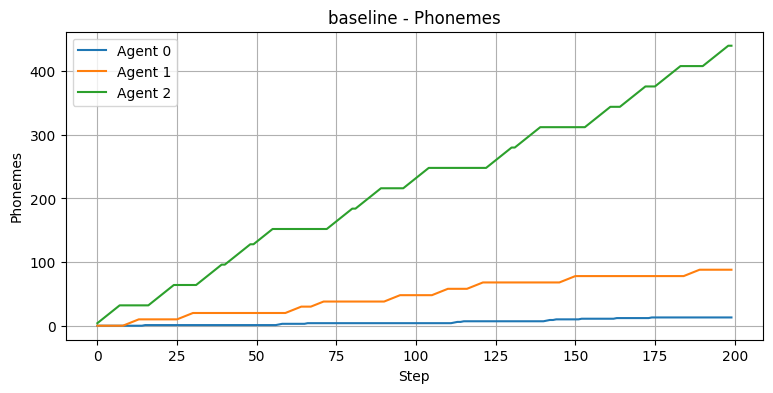

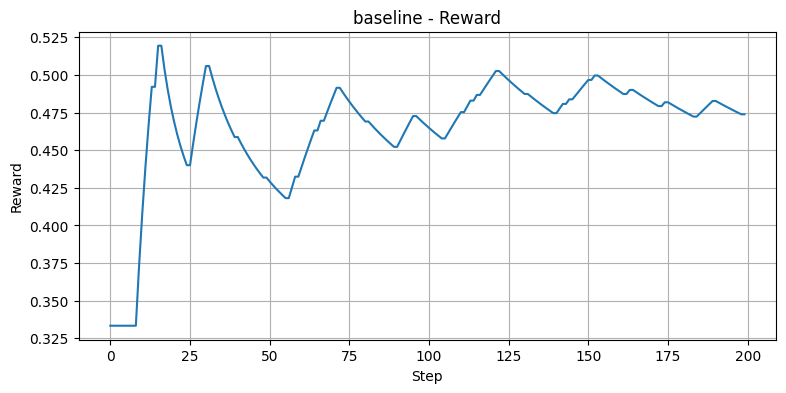

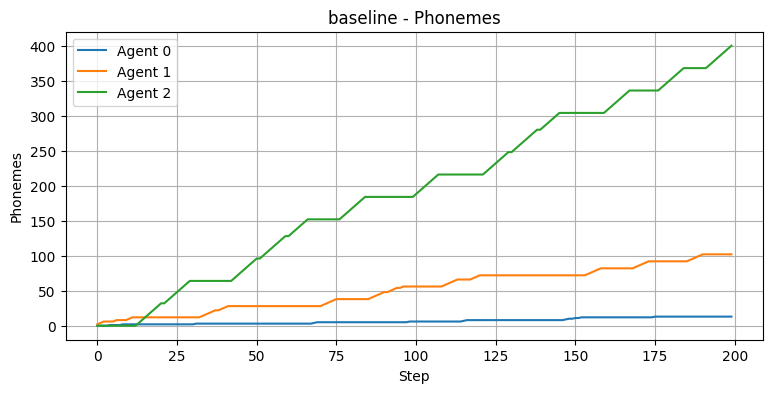

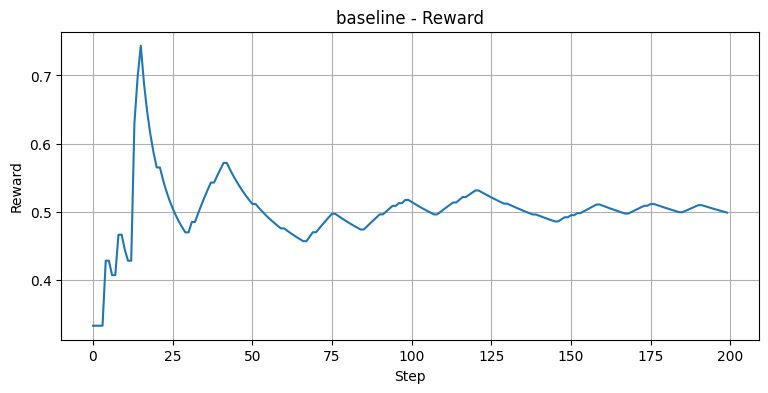

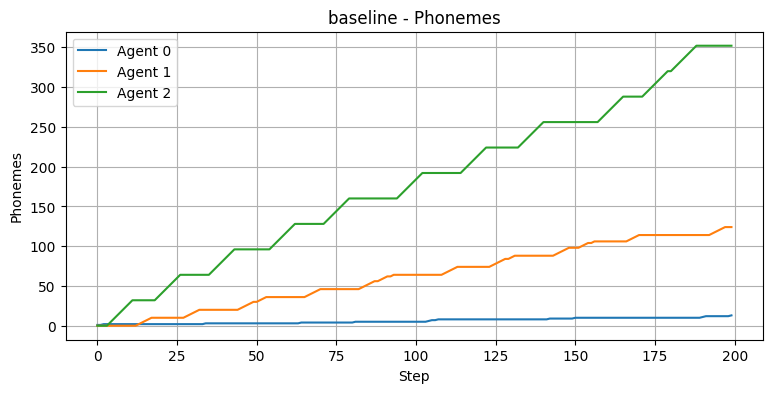

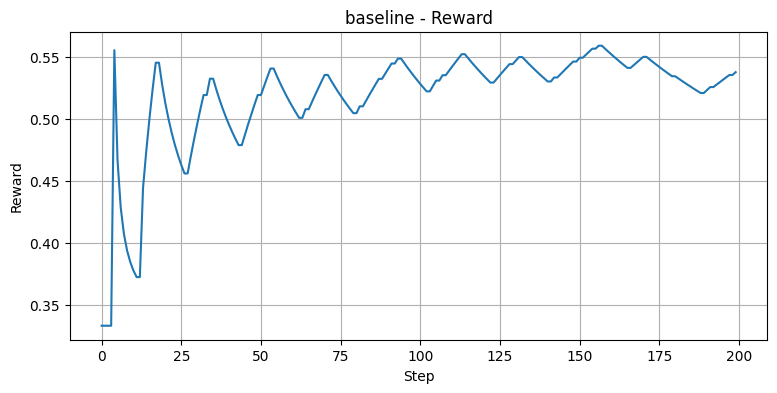

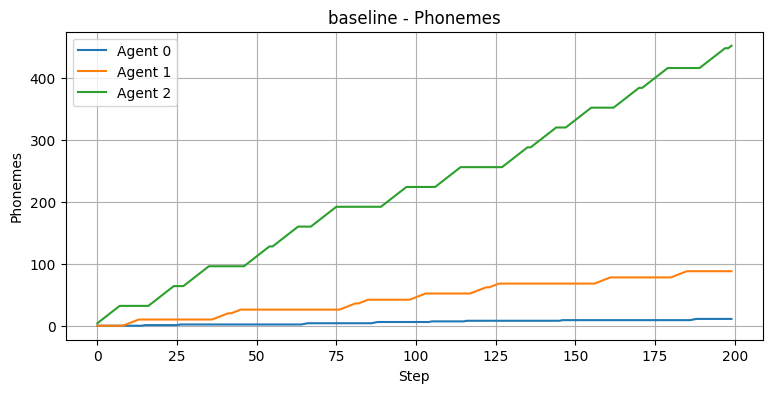

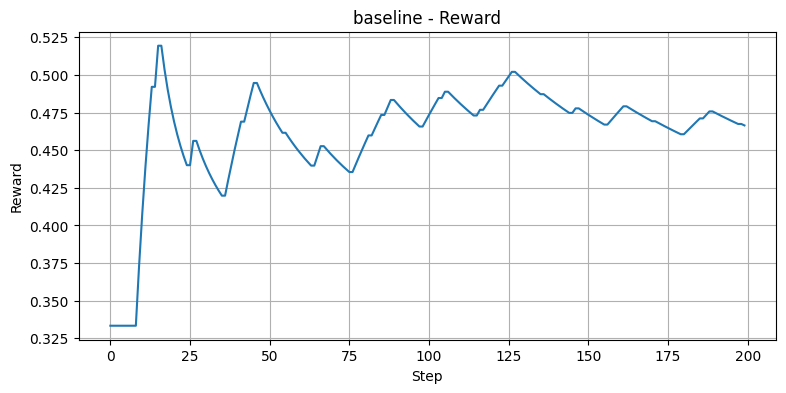

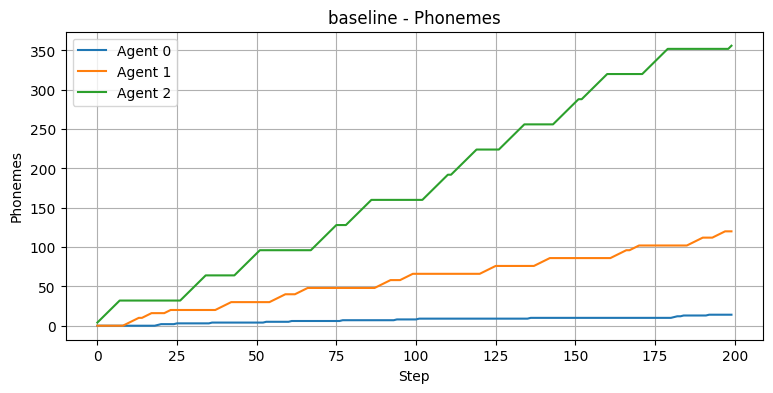

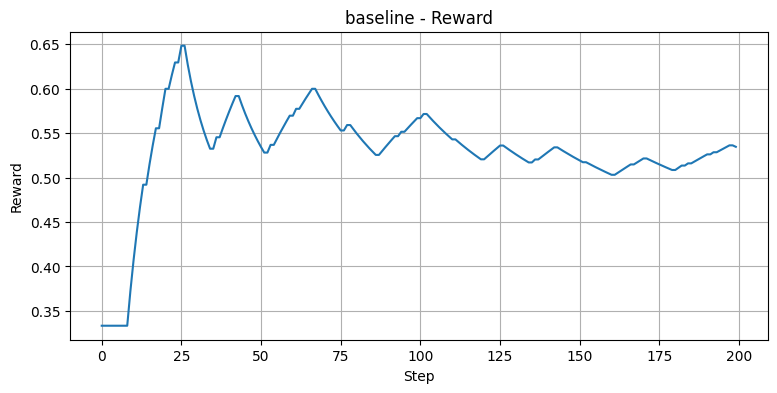

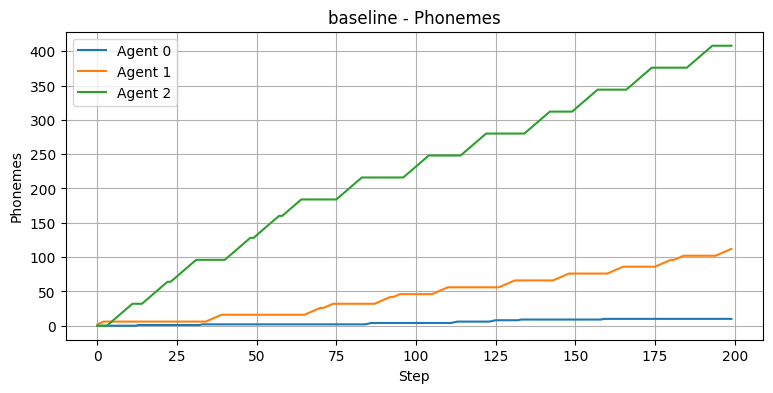

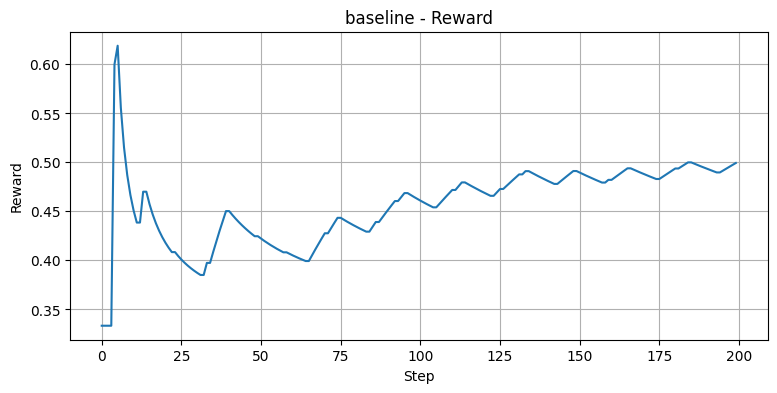

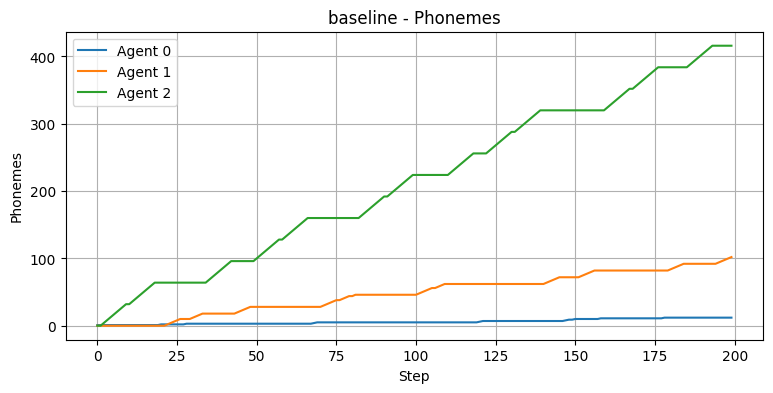

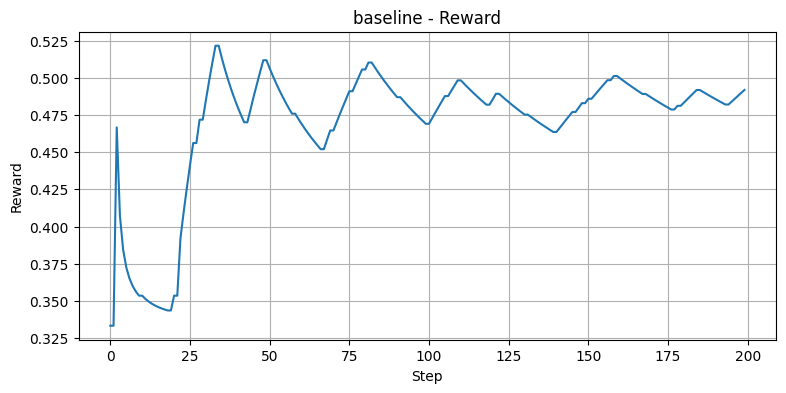

In [4]:
ph, rw = [], []
for i in range(10): 
    p, r = run_env(env, actions)
    plot_results(p, r, 'baseline')

In [5]:
for i in ph:
    plot_results(ph[i], rw[i], 'baseline')

In [6]:
import random

energies = [0.2, 0.5, 0.3]  # agent 0, 1, 2
agents = [0, 1, 2]

# Normalize to probabilities
total = sum(energies)
probs = [e / total for e in energies]

# Sample one agent
chosen = random.choices(agents, weights=probs, k=1)[0]
print(chosen)

2


In [7]:
# env = GuestEnv(max_steps=200, reward_shaping=False)
# env.agent_params[0].update({
#     'min_energy_to_speak': 0.6,
#     'energy_gain': 0.01,
#     'energy_decay': 0.15,
#     'max_speaking_time': 2,
#     'phonemes_per_step': 1
# })
# env.agent_params[1].update({
#     'min_energy_to_speak': 0.3,
#     'energy_gain': 0.05,
#     'energy_decay': 0.10,
#     'max_speaking_time': 5,
#     'phonemes_per_step': 2
# })
# env.agent_params[2].update({
#     'min_energy_to_speak': 0.1,
#     'energy_gain': 0.10,
#     'energy_decay': 0.05,
#     'max_speaking_time': 8,
#     'phonemes_per_step': 4
# })

# actions = [0]*200
# ph, rw = run_env(env, actions)

In [8]:
import numpy as np

class SpeakerSampler:
    def __init__(self, n_agents=3, seed=None):
        self.n = n_agents
        self.rng = np.random.default_rng(seed)

    def sample(
        self,
        energies = [0.2, 0.5, 0.3],                 # list/array of length n
        last_speaker=None,        # int or None
        tau=0.8,                  # temperature (0.3-1.5 is a good range)
        self_inhibit=0.85,        # <1 means slight penalty to repeat speaker
        eps_explore=0.02,         # ε-greedy exploration prob
        floor=1e-6                # probability floor
    ):
        energies = np.asarray(energies, dtype=float)
        # Safety: handle negatives/NaNs
        energies = np.clip(np.nan_to_num(energies, nan=0.0), 0.0, None)

        # Optional ε-greedy uniform exploration
        if self.rng.random() < eps_explore:
            return int(self.rng.integers(0, self.n))

        # Apply floor + self-inhibition
        w = energies + floor
        if last_speaker is not None:
            w[last_speaker] *= self_inhibit

        # Tempered softmax via power transform (equivalent to exp(log(w)/tau))
        gamma = 1.0 / max(tau, 1e-6)
        logits = np.log(w) * gamma

        # Gumbel-max trick for a crisp categorical draw (stable + avoids underflow)
        gumbel = -np.log(-np.log(self.rng.random(self.n)))
        choice = int(np.argmax(logits + gumbel))
        return choice



test = SpeakerSampler()
for i in range(10):
    print(test.sample())

2
0
2
1
0
1
1
0
1
2


In [9]:
import random

energies = [0.2, 0.5, 0.3]  # agent 0, 1, 2
agents = [0, 1, 2]

# Normalize to probabilities
total = sum(energies)
probs = [e / total for e in energies]

# Sample one agent
chosen = random.choices(agents, weights=probs, k=1)[0]
for i in range(10):
    chosen = random.choices(agents, weights=probs, k=1)[0]
    print(chosen)

1
1
1
1
1
1
1
2
1
1


In [10]:

rng = np.random.default_rng(47)

energies = np.array(energies, dtype=float)
total = energies.sum()

if total <= 0:
    # fallback: uniform choice if no energy
    print(f"fallback - {rng.choice(agents)}")

# normalize to probabilities
probs = energies / total

# sample one agent
choice = rng.choice(agents, p=probs)
print(f"agent - {int(choice)}")

agent - 2
